# PERAMALAN PENJUALAN PRODUK INSTAX (SARIMA VS HOLT-WINTERS)

AUTHOR : Ana Khaerunisa

DATASET : instax_sales_transaction_data.csv (Daily Transactions)

METODOLOGI : CRISP-DM

## Import Library

In [1]:
!pip install pmdarima -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings

# Konfigurasi Tampilan
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("✅ Library berhasil diinstall dan diimport.")

✅ Library berhasil diinstall dan diimport.


## 1. BUSINESS UNDERSTANDING

* Tujuan: Memprediksi jumlah penjualan (Qty) bulanan untuk perencanaan stok
* Masalah: Data memiliki tren kenaikan dan pola musiman yang fluktuatif.
* Metode: Membandingkan SARIMA dan Holt-Winters untuk mencari error terkecil (MAPE).

## 2. DATA UNDERSTANDING

In [3]:
df_raw = pd.read_csv('instax_sales_transaction_data.csv')

# Konversi kolom Tanggal ke tipe Datetime
df_raw['Tanggal'] = pd.to_datetime(df_raw['Tanggal'])

print(f"Data Raw Berhasil Dimuat: {df_raw.shape[0]} baris transaksi.")
print(f"Periode Data: {df_raw['Tanggal'].min().date()} s/d {df_raw['Tanggal'].max().date()}")
print("\nSampel 5 Data Teratas:")
display(df_raw.head())

Data Raw Berhasil Dimuat: 12334 baris transaksi.
Periode Data: 2022-05-01 s/d 2025-05-01

Sampel 5 Data Teratas:


,Tanggal,Tahun,Bulan,Hari,Kategori,Nama_Produk,Lokasi_Toko,Metode_Bayar,Harga_Satuan,Qty,Diskon_IDR,Total_Penjualan
0,2022-05-01,2022,5,Sunday,Film,Instax Mini Film (20s),Tokopedia Official,Kartu Kredit,185000,1,9250,175750
1,2022-05-01,2022,5,Sunday,Film,Instax Mini Film (20s),Tokopedia Official,Kartu Kredit,185000,1,0,185000
2,2022-05-01,2022,5,Sunday,Film,Instax Mini Film (20s),Shopee Mall,E-Wallet (Gopay/OVO),185000,2,0,370000
3,2022-05-01,2022,5,Sunday,Kamera,Instax Mini 11,Shopee Mall,Paylater,1100000,1,0,1100000
4,2022-05-01,2022,5,Sunday,Film,Instax Mini Film (20s),Shopee Mall,E-Wallet (Gopay/OVO),185000,2,0,370000


## 3. DATA PREPARATION

### 3.1 Agregasi Data (Daily -> Monthly)

Penelitian fokus pada 'Penjualan Bulanan'. Maka menjumlahkan 'Qty' berdasarkan bulan.

In [4]:
df_monthly = df_raw.set_index('Tanggal').resample('MS')['Qty'].sum().reset_index()
df_monthly.columns = ['Bulan', 'Total_Qty']
df_monthly.set_index('Bulan', inplace=True)

print(f"Transformasi Selesai: Data dikonversi menjadi {len(df_monthly)} data bulanan.")

Transformasi Selesai: Data dikonversi menjadi 37 data bulanan.


### 3.2 Visualisasi Data Hasil Agregasi

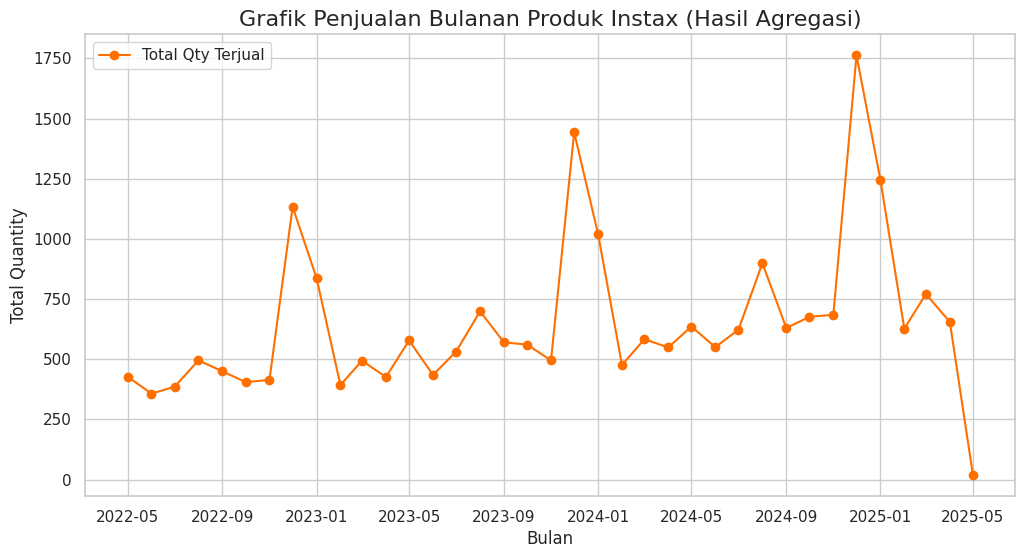

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Total_Qty'], marker='o', color='#FF6F00', label='Total Qty Terjual')
plt.title('Grafik Penjualan Bulanan Produk Instax (Hasil Agregasi)', fontsize=16)
plt.ylabel('Total Quantity')
plt.xlabel('Bulan')
plt.legend()
plt.show()

In [6]:
print(f"Data Awal: {len(df_monthly)} bulan.")
df_monthly = df_monthly.iloc[:-1]
print(f"Data Setelah Pembersihan: {len(df_monthly)} bulan (Bulan terakhir dihapus).")

Data Awal: 37 bulan.
Data Setelah Pembersihan: 36 bulan (Bulan terakhir dihapus).


### 3.3 Train-Test Split

Mengambil 12 bulan terakhir sebagai data uji (Testing)

In [7]:
test_months = 12
train_data = df_monthly.iloc[:-test_months]
test_data = df_monthly.iloc[-test_months:]

print(f"Jumlah Data Training: {len(train_data)} bulan (Mei 2022 - {train_data.index[-1].strftime('%b %Y')})")
print(f"Jumlah Data Testing : {len(test_data)} bulan ({test_data.index[0].strftime('%b %Y')} - {test_data.index[-1].strftime('%b %Y')})")

Jumlah Data Training: 24 bulan (Mei 2022 - Apr 2024)
Jumlah Data Testing : 12 bulan (May 2024 - Apr 2025)


## 4. MODELING (SARIMA vs HOLT-WINTERS)

### 4.1 MODEL 1 - HOLT-WINTERS EXPONENTIAL SMOOTHING

Metode ini cocok untuk data dengan Tren dan Musiman (Seasonal)

In [8]:
hw_model = ExponentialSmoothing(
    train_data['Total_Qty'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

hw_pred = hw_model.forecast(len(test_data))
hw_pred = pd.Series(hw_pred, index=test_data.index)
print("✅ Model Holt-Winters Selesai Dilatih.")

✅ Model Holt-Winters Selesai Dilatih.


### 4.2 MODEL 2 - SARIMA (Seasonal ARIMA)

Auto-ARIMA mencari parameter (p,d,q)(P,D,Q)m terbaik secara otomatis

In [9]:
sarima_model = auto_arima(
    train_data['Total_Qty'],
    seasonal=True,
    m=12,              # Periode musiman 12 bulan
    stepwise=True,
    suppress_warnings=True,
    trace=False,        # Set True jika ingin melihat log proses pencarian
    D=1,           # Batasi maksimal seasonal differencing menjadi 1
    max_d=1            # Batasi maksimal non-seasonal differencing menjadi 1
)

print(f"✅ Model SARIMA Selesai. Parameter Terbaik: {sarima_model.order} x {sarima_model.seasonal_order}")
sarima_pred = sarima_model.predict(n_periods=len(test_data))
sarima_pred = pd.Series(sarima_pred, index=test_data.index)

✅ Model SARIMA Selesai. Parameter Terbaik: (0, 0, 0) x (0, 1, 0, 12)


## 5. EVALUATION

### 5.1 Fungsi Perhitungan

In [10]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"--- Kinerja {model_name} ---")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%") # Mean Absolute Percentage Error
    return mape

### 5.2 Hitung Error

In [11]:
mape_hw = calculate_metrics(test_data['Total_Qty'], hw_pred, "Holt-Winters")
print("")
mape_sarima = calculate_metrics(test_data['Total_Qty'], sarima_pred, "SARIMA")

--- Kinerja Holt-Winters ---
MAE  : 71.87
RMSE : 96.26
MAPE : 8.21%

--- Kinerja SARIMA ---
MAE  : 60.75
RMSE : 73.74
MAPE : 7.24%


5.3 Visualisasi Perbandingan Prediksi vs Aktual

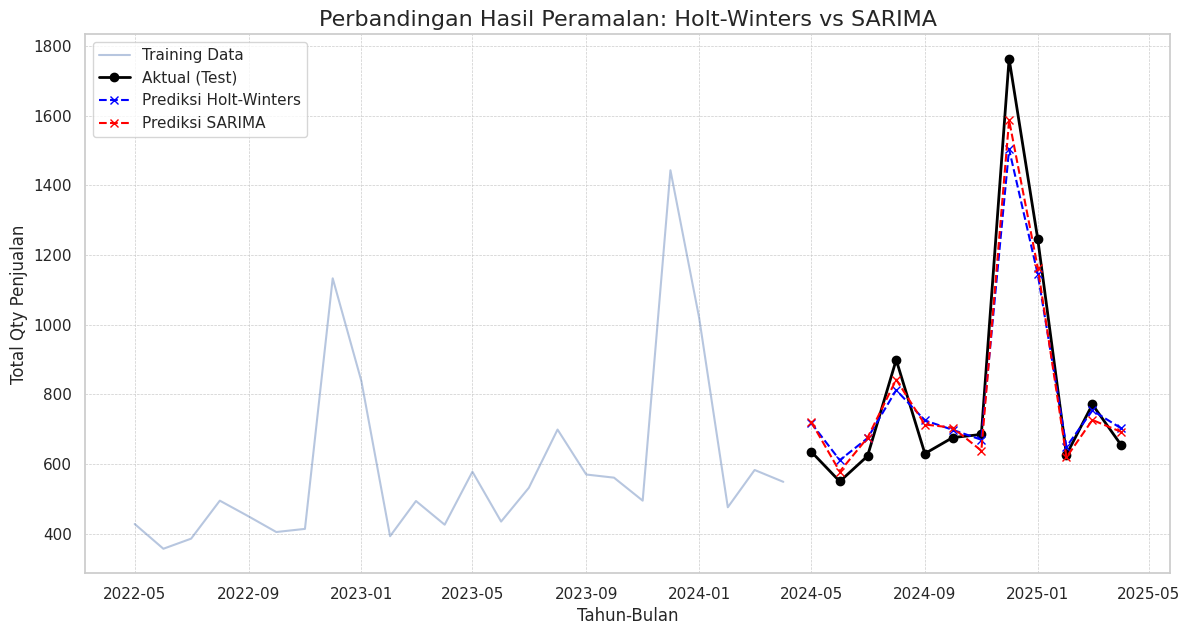

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Total_Qty'], label='Training Data', alpha=0.4)
plt.plot(test_data.index, test_data['Total_Qty'], label='Aktual (Test)', color='black', linewidth=2, marker='o')
plt.plot(test_data.index, hw_pred, label='Prediksi Holt-Winters', linestyle='--', color='blue', marker='x')
plt.plot(test_data.index, sarima_pred, label='Prediksi SARIMA', linestyle='--', color='red', marker='x')

plt.title('Perbandingan Hasil Peramalan: Holt-Winters vs SARIMA', fontsize=16)
plt.xlabel('Tahun-Bulan')
plt.ylabel('Total Qty Penjualan')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## 6. DEPLOYMENT PREPARATION (SAVE MODEL)

In [13]:
model_files = {
    'model_holtwinters.pkl': hw_model,
    'model_sarima.pkl': sarima_model
}

for filename, model in model_files.items():
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"✅ Berhasil menyimpan: {filename}")

print("\n💾 Kedua model telah disimpan. Siap digunakan untuk Deployment/Dashboard.")

✅ Berhasil menyimpan: model_holtwinters.pkl
✅ Berhasil menyimpan: model_sarima.pkl

💾 Kedua model telah disimpan. Siap digunakan untuk Deployment/Dashboard.


## UJI COBA - FORECASTING MASA DEPAN (NEXT 6 MONTHS - COMPARISON)

### 1. Generate tanggal masa depan

In [14]:
last_date = df_monthly.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

### 2. Prediksi Menggunakan Kedua Model

In [15]:
# Holt-Winters Forecast
future_hw = hw_model.forecast(6)

# SARIMA Forecast
future_sarima = sarima_model.predict(n_periods=6)

### 3. Buat DataFrame Perbandingan

In [16]:
forecast_df = pd.DataFrame({
    'Bulan': future_dates,
    'Prediksi_HoltWinters': future_vals.astype(int) if 'future_vals' in locals() else future_hw.astype(int), # Fallback safety
    'Prediksi_SARIMA': future_sarima.astype(int)
})

# Koreksi variabel agar tidak error jika dijalankan terpisah
forecast_df['Prediksi_HoltWinters'] = future_hw.astype(int)

print("Tabel Prediksi Masa Depan:")
display(forecast_df)

Tabel Prediksi Masa Depan:


,Bulan,Prediksi_HoltWinters,Prediksi_SARIMA
2024-05-01,2025-05-01,718,721
2024-06-01,2025-06-01,611,578
2024-07-01,2025-07-01,674,675
2024-08-01,2025-08-01,812,842
2024-09-01,2025-09-01,725,713
2024-10-01,2025-10-01,698,704


### 4. Visualisasi Final (Perbandingan 3 Garis)

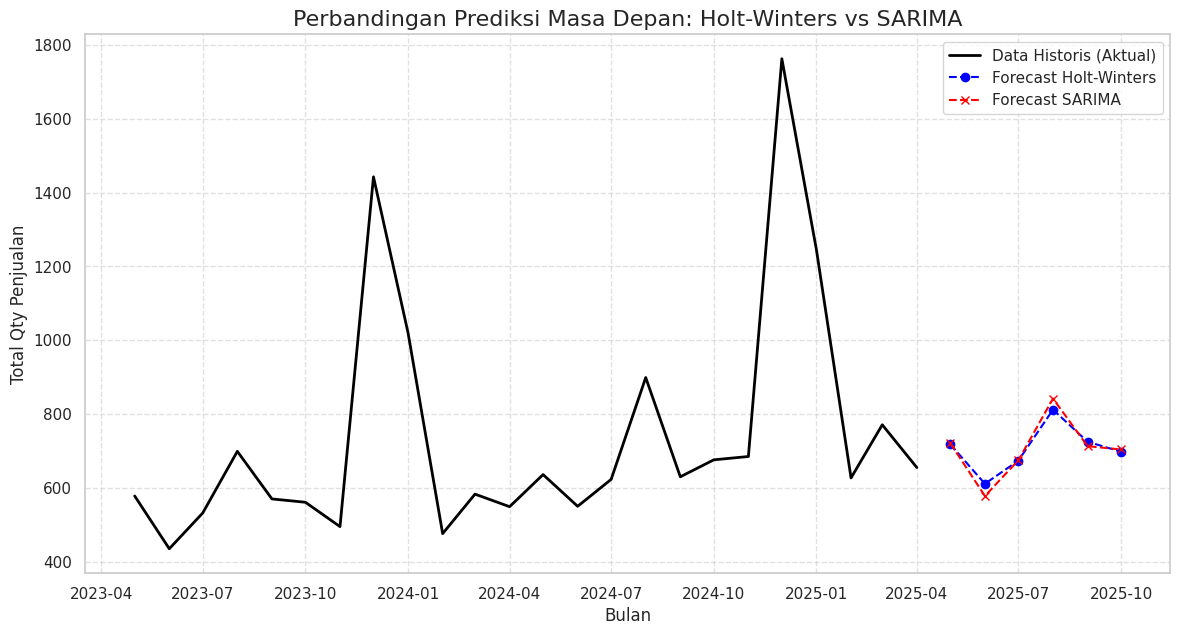

In [17]:
plt.figure(figsize=(14, 7))

# Plot Data Historis (Ambil 2 tahun terakhir agar grafik tidak terlalu padat)
recent_history = df_monthly.iloc[-24:]
plt.plot(recent_history.index, recent_history['Total_Qty'], label='Data Historis (Aktual)', color='black', linewidth=2)

# Plot Prediksi Holt-Winters
plt.plot(forecast_df['Bulan'], forecast_df['Prediksi_HoltWinters'],
         label='Forecast Holt-Winters', color='blue', linestyle='--', marker='o')

# Plot Prediksi SARIMA
plt.plot(forecast_df['Bulan'], forecast_df['Prediksi_SARIMA'],
         label='Forecast SARIMA', color='red', linestyle='--', marker='x')

plt.title('Perbandingan Prediksi Masa Depan: Holt-Winters vs SARIMA', fontsize=16)
plt.xlabel('Bulan')
plt.ylabel('Total Qty Penjualan')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()